# Flood area Segmentation

Einteilung in Überschwemmungsgebiet (Wasserbereiche auf den Bildern zuverlässig erkennt) - oder nicht.

Bei der semantischen Segmentierung wird jedes Pixel eines Bildes einer bestimmten Kategorie zugeordnet: Wasser oder nicht-Wasser.

## Daten
Daten von Kaggle: https://www.kaggle.com/code/faizalkarim/flood-area-segmentation

Datensatz enthält 290 Bilder von überschwemmten Gebieten sowie die dazugehörigen Maskenbilder, die die Wasserflächen markieren. -> Die Masken wurden mit der Open-Source-Software Label Studio erstellt.

### Anwendung des Modells:
Für Überschwemmungsanalysen, bessere Entscheidungen und Planung.

Allerdigns: Aufgrund der geringen Datenmenge sollten vortrainierte Modelle und Datenaugmentation genutzt werden.

### Struktur des Datensatzes:
- Image/: Ordner mit allen Überschwemmungsbildern
- Mask/: Ordner mit den entsprechenden Maskenbildern
- metadata.csv: CSV-Datei, die Bildnamen mit Masken verknüpft

# Modell 1 mit U-Net

![U-Net Architektur](https://datascientest.com/de/files/2021/05/u-net-architecture-1024x682.png)

## Code
Gefunden auf Kaggle: https://www.kaggle.com/code/ashikshahriar/flood-area-segmentation/notebook

Requirements: GPU (change runtime in this google colab project)

## Ergebnisse

Das trainierte Modell wird anschließend geladen, und die Bilder aus den Validierungs- und Testsätzen werden darauf angewendet und visualisiert. Metriken wie Genauigkeit, IoU, F1-Score, Precision und Recall werden berechnet, um die Leistung des Modells zu bewerten.

## Laden der Daten und Inspizieren der Daten
https://www.kaggle.com/discussions/general/51898

In [1]:
import os
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

# access data
base_dir = Path(path)
print('No of images: ', len(os.listdir(base_dir / 'Image')))
print('No of masks: ', len(os.listdir(base_dir / 'Mask')))

/home/aie3/christina/flood-area-segmentation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No of images:  290
No of masks:  290


So sehen die Daten aus - zum Image gibt es die jeweilige Mask (markierte Wasserflächen)

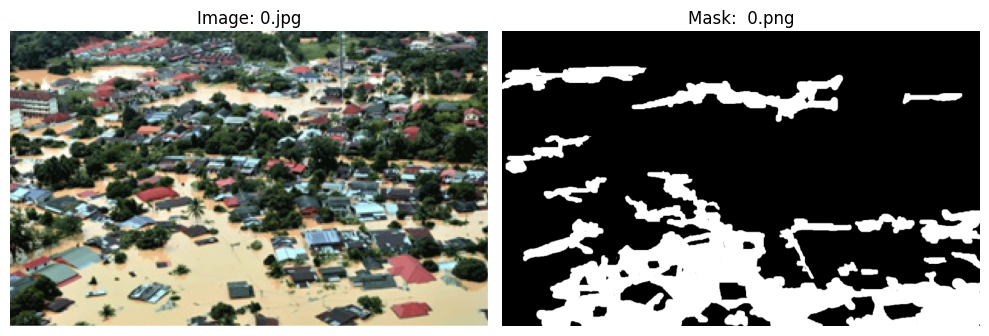

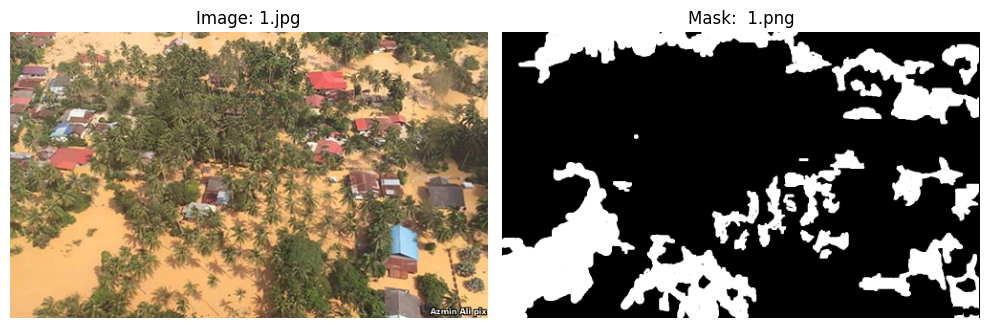

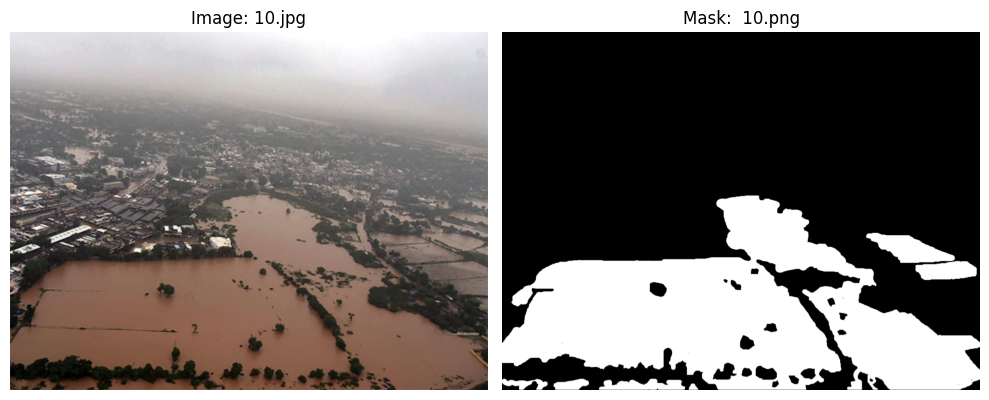

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

image_files = sorted(os.listdir(base_dir / 'Image'))
mask_files = sorted(os.listdir(base_dir / 'Mask'))

for i in range(3):

  image = Image.open(base_dir / 'Image' / image_files[i])
  mask = Image.open(base_dir / 'Mask' / mask_files[i])

  # plot
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.title(f"Image: {image_files[i]}")
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title(f"Mask:  {mask_files[i]}")
  plt.imshow(mask, cmap='gray')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

Maske wird über Bild gelegt - Maskierter Bereich wird jetzt rot dargestellt

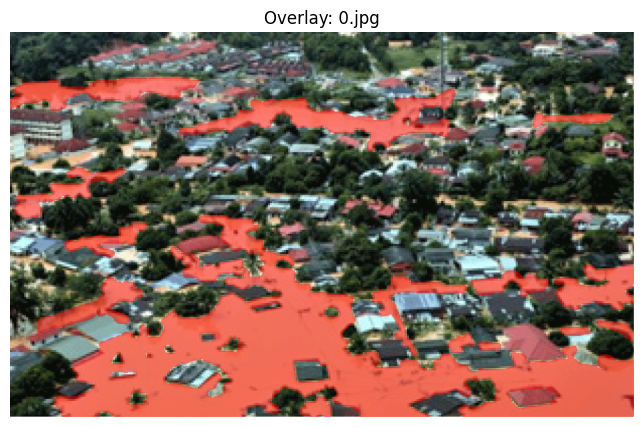

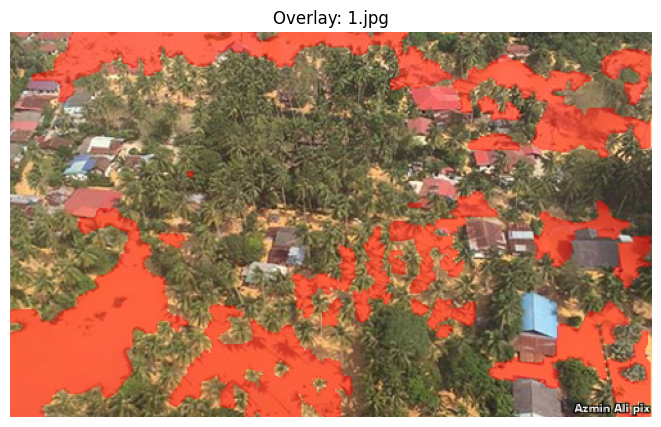

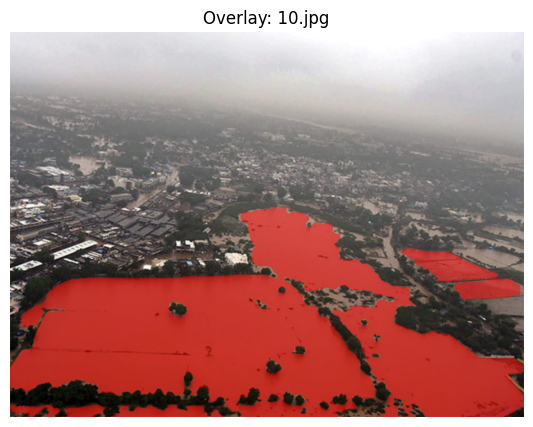

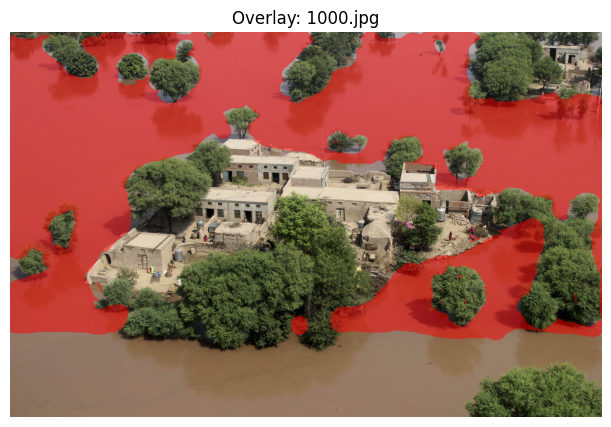

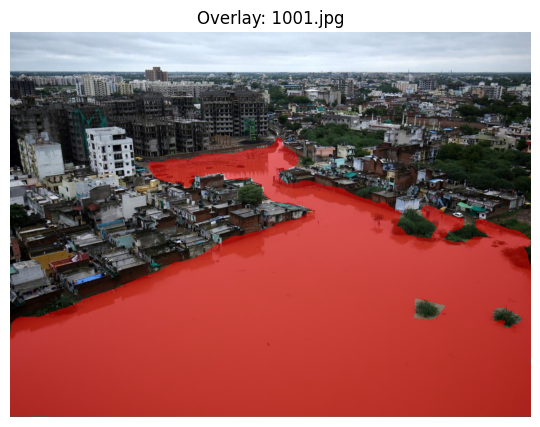

In [3]:
import numpy as np

image_dir = base_dir / 'Image'
mask_dir = base_dir / 'Mask'

def overlay_mask_on_image(num_images=5, alpha=0.5):

    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Convert to numpy arrays
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Create overlay by blending image and mask
        overlay = img_np.copy()
        overlay[mask_np > 0] = [255, 0, 0]  # Highlight mask area in red

        blended = (1 - alpha) * img_np + alpha * overlay
        blended = blended.astype(np.uint8)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title(f"Overlay: {img_file}")
        plt.imshow(blended)
        plt.axis('off')
        plt.show()

# Call the function
overlay_mask_on_image(num_images=5, alpha=0.5)

## Semantic Segmentation

Ziel ist es, aus Satellitenbildern die Wasserflächen exakt herauszufiltern. Also jedem Pixel die Klasse „Wasser“ oder „kein Wasser“ zuzuweisen.

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

2025-06-12 09:55:09.494534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749722109.511279 2338224 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749722109.516444 2338224 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749722109.531358 2338224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749722109.531374 2338224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749722109.531376 2338224 computation_placer.cc:177] computation placer alr

### Datenvorbereitung

Bildergröße (Image und Mask) wird auf 224 x 224 pixel skaliert. Image wird in 3-Kanal-Farbe (RGB) umgewandelt. Mask wird in 1-Kanal Graustufen umgewandelt (Schwarz = 0, Weiß = 255).

Normalisierung: Image und Mask bestehen ursprünglich aus Werten 0–255 (8-Bit). /255 ergibt somit Werte zwischen 0 und 1 == Normalisierung.

Gibt das Array zurück: Listen werden in NumPy-Arrays umgewandlet. Keras erwartet eine zusätzliche axis (axis =1) ... sodass wir die Form (224, 224, 1) erhalten

Batch-size: 32 Bilder werden gleichzeitig beim Training in das NN gegeben



In [5]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

def load_images_and_masks():
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")  # Grayscale

        # Normalize image and mask
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Load dataset
images, masks = load_images_and_masks()
print(images.shape)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

(290, 224, 224, 3)
Loaded 290 images and 290 masks.


### Auteilung in Train und Validation Daten
70 % Training .. 203

15 % Validierung ... 43

15 % Test ... 44

In [6]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

# First split: training set and temporary set (30% goes to temp)
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)

# Second split: divide temp set into validation and test sets (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (203, 224, 224, 3)
Val:   (43, 224, 224, 3)
Test:  (44, 224, 224, 3)


In [7]:
# Import precision, recall, f1_score and IoU Metric

import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric

#Can not load f1_metric "cannot import name 'f1_metric' from 'utils.precision_recall_f1' (unknown location)", therfore:
import tensorflow as tf
from tensorflow.keras import backend as K
import keras

@keras.saving.register_keras_serializable()
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

#### Tensorflow Speicherwachstum erlauben - verhindert Pre-Allocation

Normalerweise versucht TensorFlow beim Start den gesamten verfügbaren GPU-Speicher zu reservieren (auch wenn er noch gar nicht gebraucht wird). 

Mit `set_memory_growth = True` reserviert TensorFlow nur so viel Speicher wie gerade benötigt wird.
Wenn mehr gebraucht wird, wächst die Allokation dynamisch.



In [8]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Create model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_metric, recall_metric, f1_metric, iou_metric])
model.summary()

I0000 00:00:1749722122.017531 2338224 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76039 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1749722122.018960 2338224 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79183 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0
I0000 00:00:1749722122.020114 2338224 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79183 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:a1:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 112, 112,  │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

### Modelltraining

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50


I0000 00:00:1749722126.176936 2338606 service.cc:152] XLA service 0x7fa0a80046c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749722126.176985 2338606 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1749722126.176991 2338606 service.cc:160]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1749722126.176995 2338606 service.cc:160]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-06-12 09:55:26.308111: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749722126.868045 2338606 cuda_dnn.cc:529] Loaded cuDNN version 91001


3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5752 - f1_metric: 0.0031 - iou_metric: 0.0016 - loss: 0.6921 - precision_metric: 0.1089 - recall_metric: 0.0016             

I0000 00:00:1749722137.592696 2338606 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5724 - f1_metric: 0.0024 - iou_metric: 0.0012 - loss: 0.6892 - precision_metric: 0.0943 - recall_metric: 0.0012 - val_accuracy: 0.5640 - val_f1_metric: 0.0062 - val_iou_metric: 0.0031 - val_loss: 0.6751 - val_precision_metric: 0.7258 - val_recall_metric: 0.0031
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5766 - f1_metric: 0.0748 - iou_metric: 0.0553 - loss: 0.6579 - precision_metric: 0.7365 - recall_metric: 0.0820 - val_accuracy: 0.5713 - val_f1_metric: 0.1150 - val_iou_metric: 0.0610 - val_loss: 0.5988 - val_precision_metric: 0.5889 - val_recall_metric: 0.0637
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6420 - f1_metric: 0.4063 - iou_metric: 0.2801 - loss: 0.6219 - precision_metric: 0.7066 - recall_metric: 0.3546 - val_accuracy: 0.4187 - val_f1_metric: 0.6059 - val_iou_metric: 0.4350 - val_loss: 0.6958 - val_precision_metric: 0.4365 - val_recall_metric: 0.9922
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0

### Modell Evaluieren

Loss-Plot: wie gut das Modell im Laufe der Epochen lernt (Trainings- und Validierungsfehler) - zB Overfitting, wenn der Validierungs-Loss steigt, während der Trainings-Loss sinkt.

Accuracy-Plot: wie genau dein Modell bei der Segmentierung ist – sowohl auf den Trainings- als auch Validierungsdaten. Man erkennt, ob das Modell besser wird und wie stabil die Genauigkeit ist.

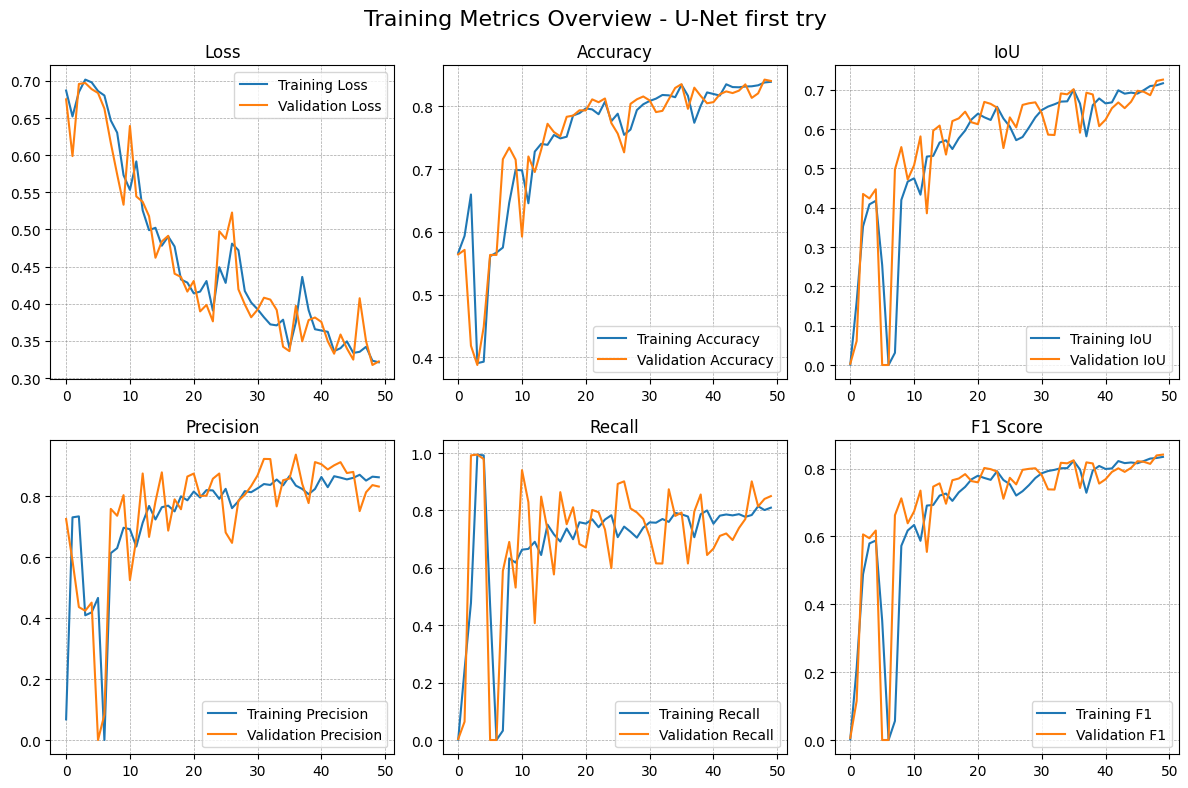

In [11]:
from datetime import datetime

# Plot training history
# Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Accuracy')

#IoU
plt.subplot(2, 3, 3)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('IoU')

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision_metric'], label='Training Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall_metric'], label='Training Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1')
plt.plot(history.history['val_f1_metric'], label='Validation F1')
plt.title('F1 Score')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

plt.suptitle('Training Metrics Overview - U-Net first try', fontsize=16)
plt.tight_layout()
plt.savefig(f'./img/training_metrics_first_try_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
plt.show()

Was sagen uns die Plots:

Loss: Training Loss sinkt -> Modell lernt gut; Validation Loss schwankt leicht (denke dass die 58 Bilder nicht wirklich aussagekräftig sind) aber trotzdem Stabil (in der Nähe des Training Loss und kein auseinanderklaffen) -> kein Overfitting -> nach 50 Epochs bei ca 0.3

Accuracy: Trainings- als auch Validierungsgenauigkeit steigen deutlich und stabil und liegen nahe beinander (also verallgemeinert das Modell gut) -> nach 50 Epochs bei ca. 85%

Modell ist präzise und man erkennt kein Under- oder Overfitting

#### Vorhersagen visualisieren

Man sieht das Predicted Mask etwas verschwommen ist -> 85% Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


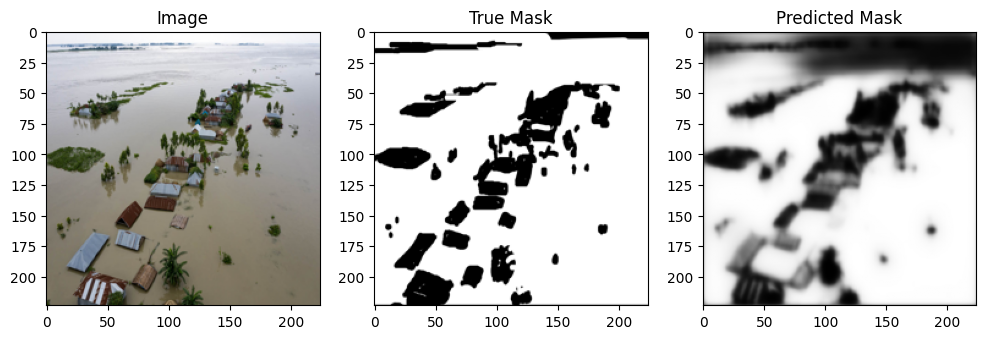

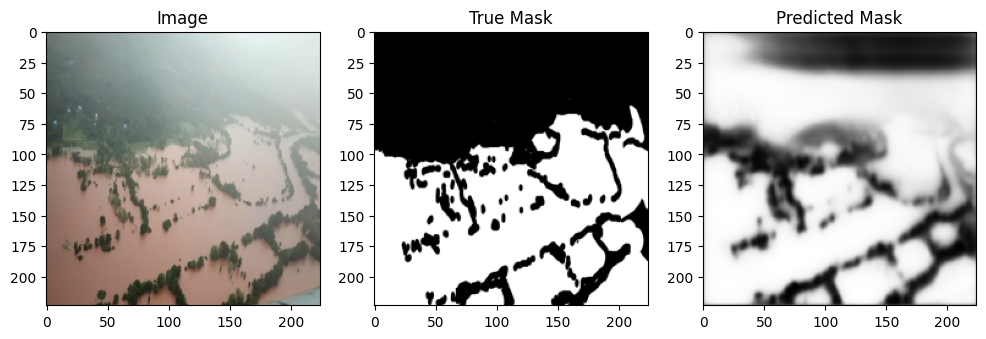

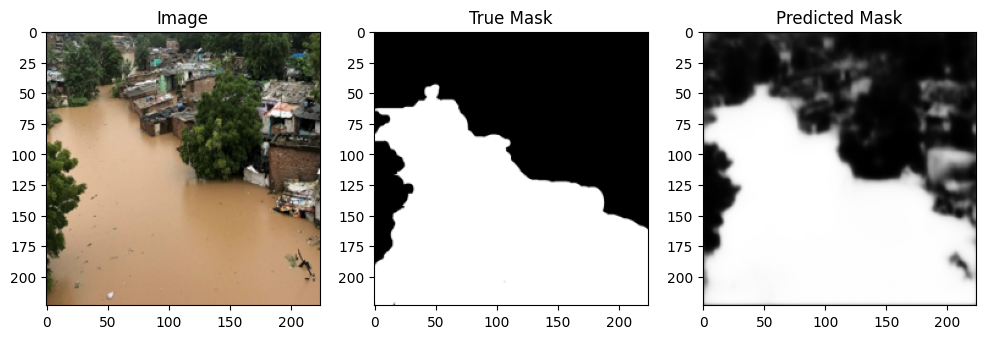

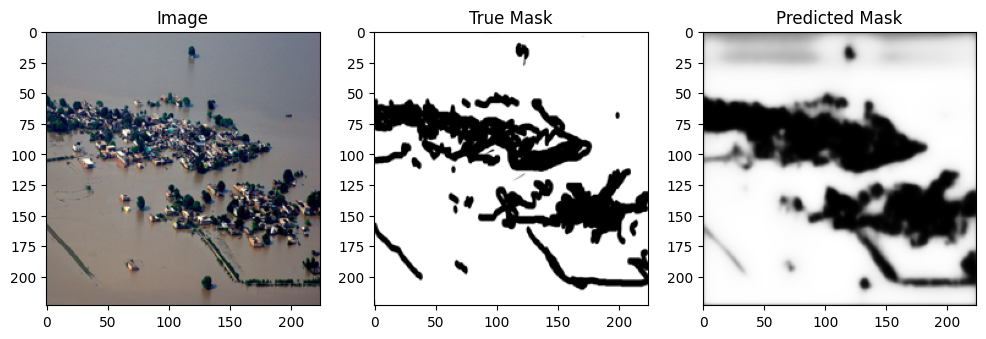

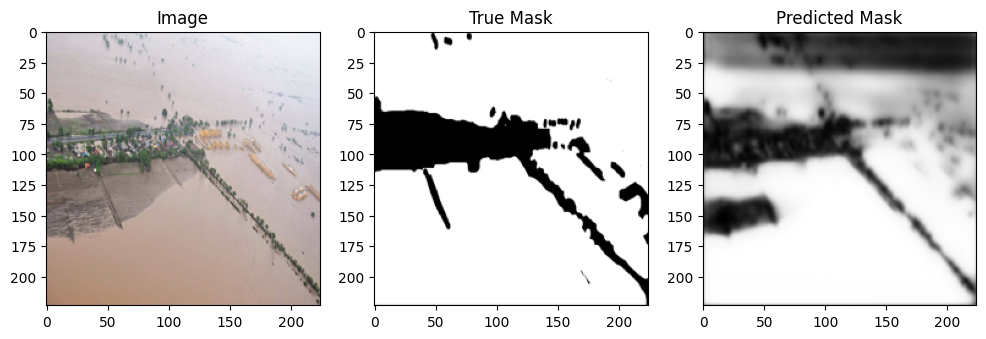

In [12]:
# Visualize predictions
def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions()

### Modell evaluieren mit Testdaten

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Prediction and binarization
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true_binary = (y_test > 0.5).astype(int)

# Flatten
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Output
print("\n===== Final Test Evaluation =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  

===== Final Test Evaluation =====
Precision: 0.8636
Recall:    0.8193
F1 Score:  0.8409
IoU:       0.7254


Precision 92,62%: von allen überfluteten/Wasser Pixel warend soviele tatsächlich korrekt -> hohe Präzision (wenig falsche positive Vorhersagen)

Recall 66,13 %: non allen tatsächlich positiven Pixeln hat das Modell 66,13 % korrekt erkannt -> mittelmäsig, da einige überflutete Bereiche nicht erkannt werden (also falsche negative) 

F1 Score 77,17 %: Mittel von Precision und Recall -> Wert ist gut

IoU 62,82%: Überlappung zwischen vorhergesagter und tatsächlicher Maske -> soviel stimmt von der vorhergesagten Fläche mit der Realität überein. -> Wert ist gut

#### Vergleich der Metriken für Train, Validation und Test

In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score

metrics_summary = pd.DataFrame({
    "Set": ["Train", "Val", "Test"],
    "Accuracy": [
        history.history['accuracy'][-1], 
        history.history['val_accuracy'][-1], 
        accuracy_score(y_true_flat, y_pred_flat)
    ],
    "Precision": [
        history.history['precision_metric'][-1], 
        history.history['val_precision_metric'][-1], 
        precision
    ],
    "Recall": [
        history.history['recall_metric'][-1], 
        history.history['val_recall_metric'][-1], 
        recall
    ],
    "F1 Score": [
        history.history['f1_metric'][-1], 
        history.history['val_f1_metric'][-1], 
        f1
    ],
    "IoU": [
        history.history['iou_metric'][-1], 
        history.history['val_iou_metric'][-1], 
        iou
    ]
})

print("\n===== Training, Validation und Test Metriken =====")
print(metrics_summary.to_string(index=False, float_format="%.4f"))



===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8389     0.8628  0.8098    0.8344 0.7165
  Val    0.8403     0.8323  0.8501    0.8411 0.7258
 Test    0.8772     0.8636  0.8193    0.8409 0.7254


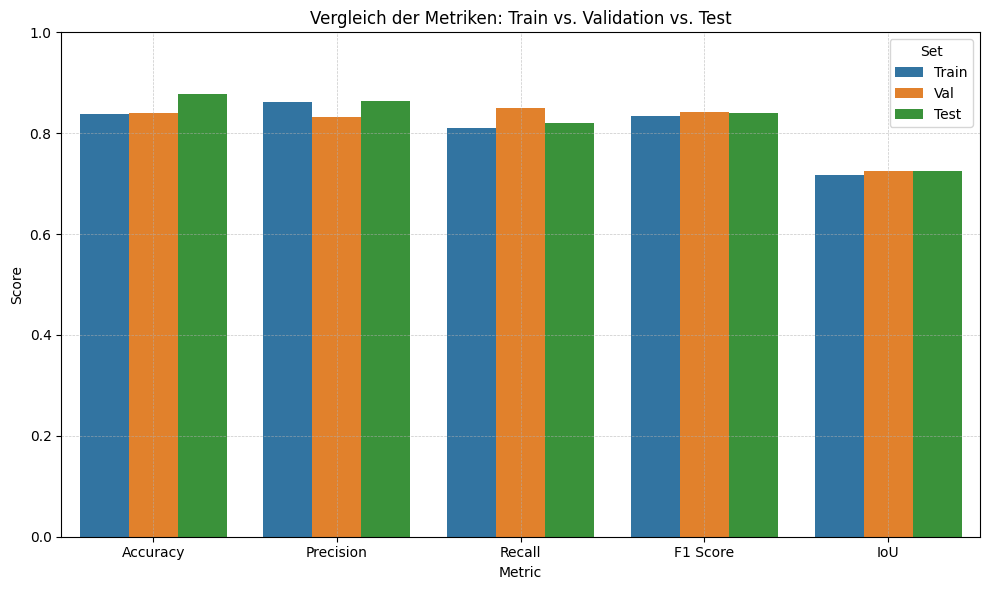

In [15]:
import matplotlib.pyplot as plt

metrics_summary_melted = metrics_summary.melt(id_vars="Set", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
import seaborn as sns
sns.barplot(data=metrics_summary_melted, x="Metric", y="Score", hue="Set")
plt.ylim(0.0, 1.0)
plt.title("Vergleich der Metriken: Train vs. Validation vs. Test")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

## Model speichern

In [16]:
# saves the trained model to the file
model.save('./trained_models/flood_segmentation_model.keras')

# val_accuracy: 0.8501 - val_iou_metric: 0.7154 - val_loss: 0.3139

### Modell und Variablen löschen - Cleanup


In [17]:
import gc
import tensorflow as tf
from keras import backend as K

# Delete model explicitly
del model
K.clear_session()
tf.keras.backend.clear_session()

del X_train, X_val, y_train, y_val
# garbage collection
gc.collect()

0

### Vorhersagen mit Überschwemmungsbildern aus Österreich
Test ob das gespeicherte Model ist nutzbar

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


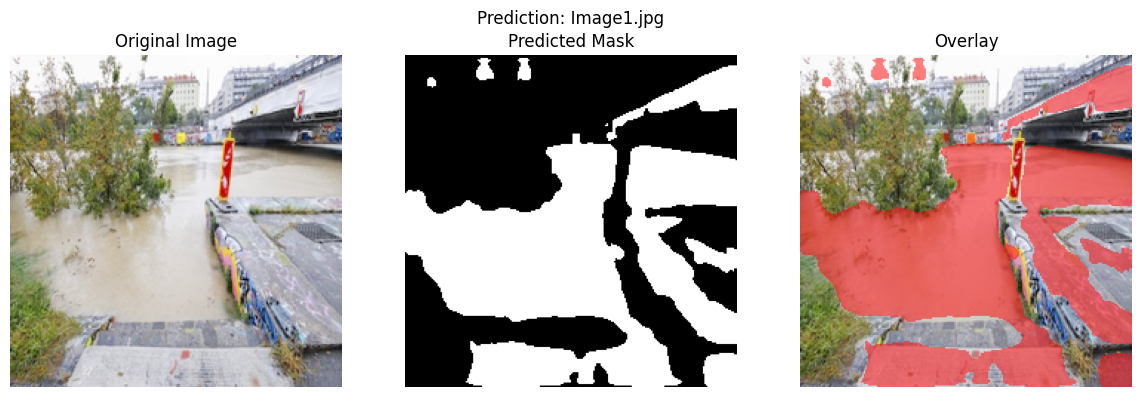

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


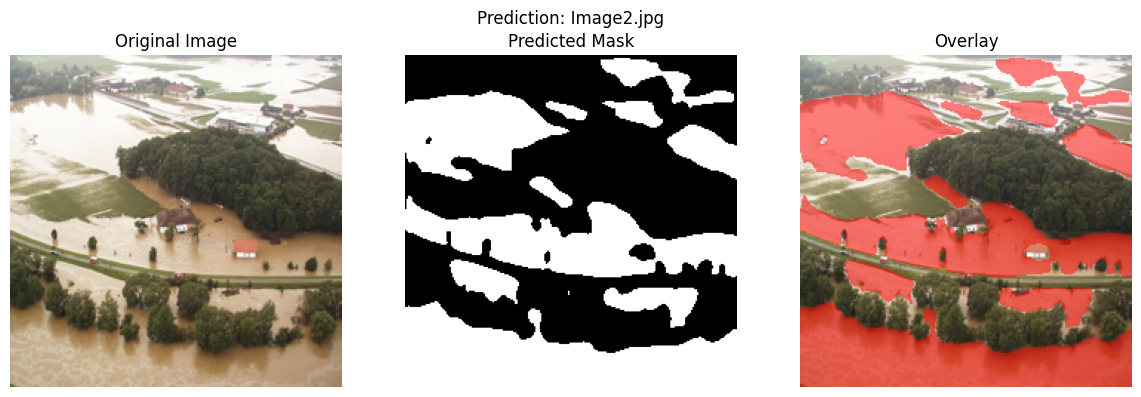

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


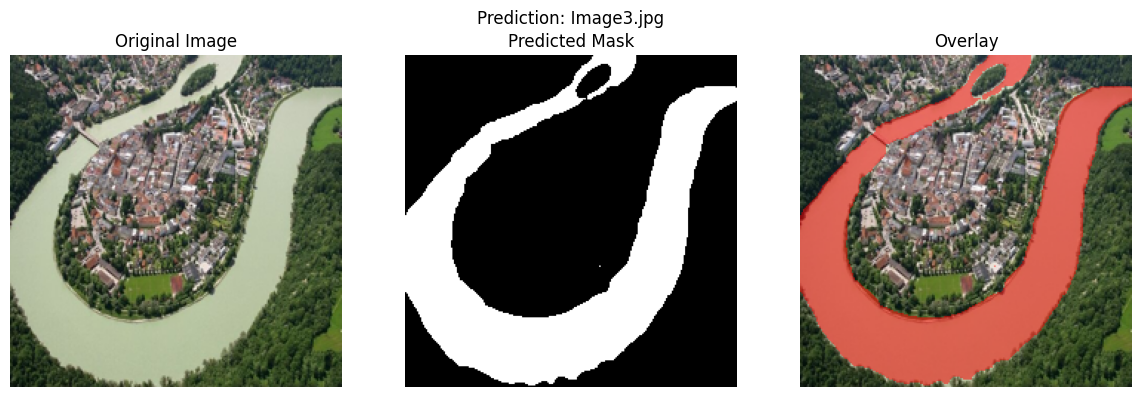

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


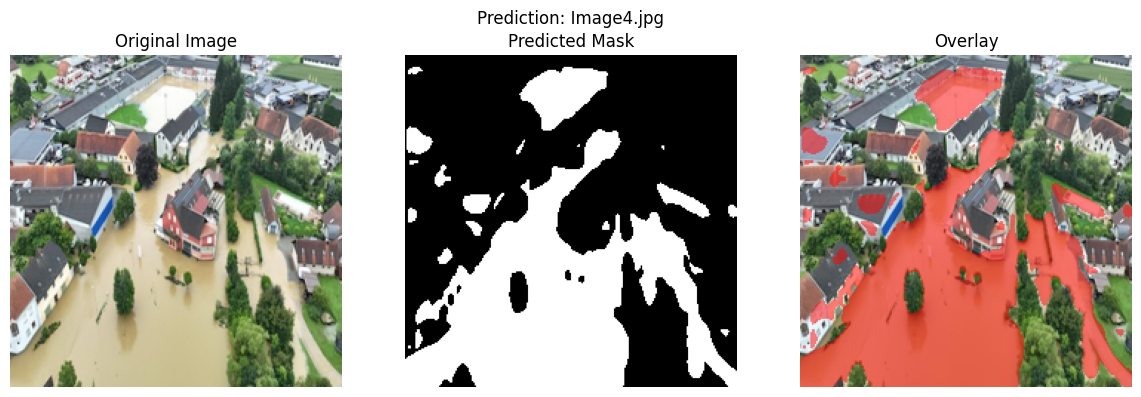

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


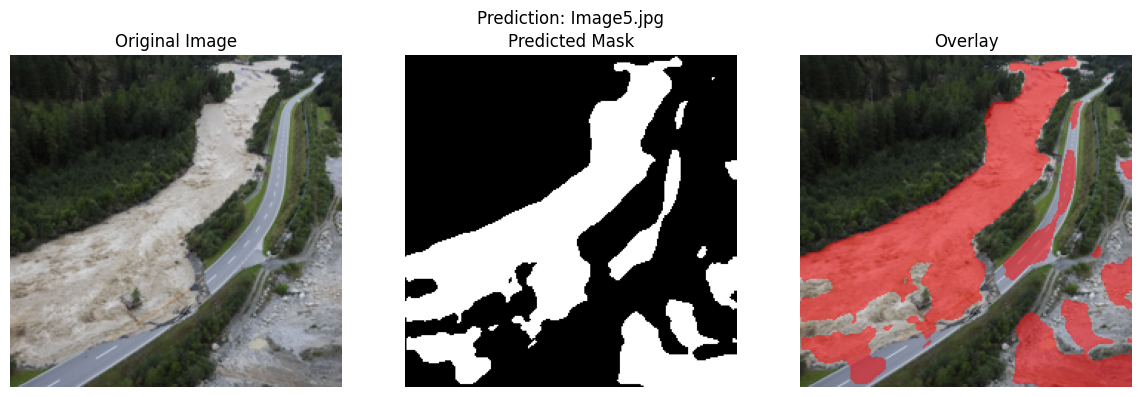

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


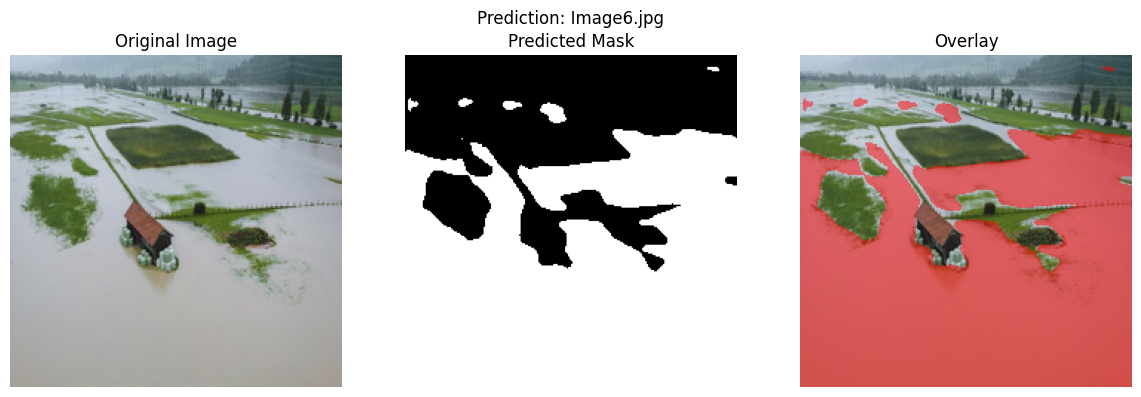

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


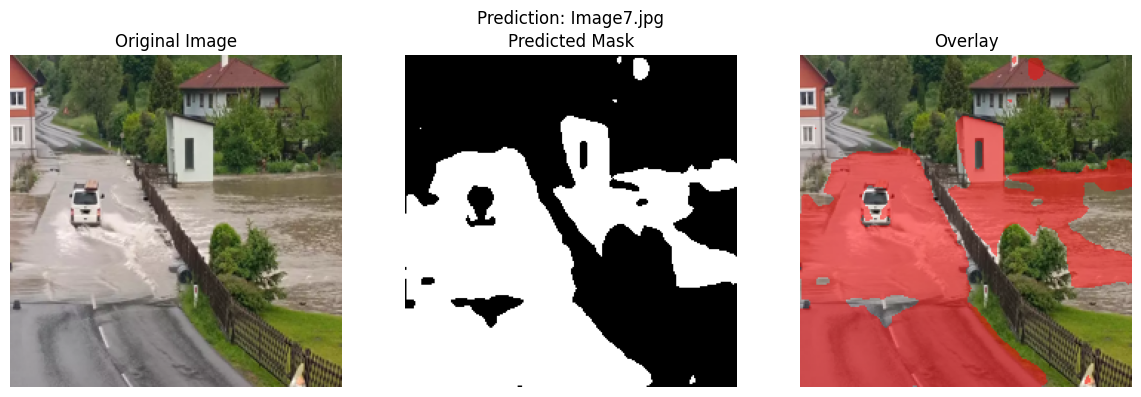

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


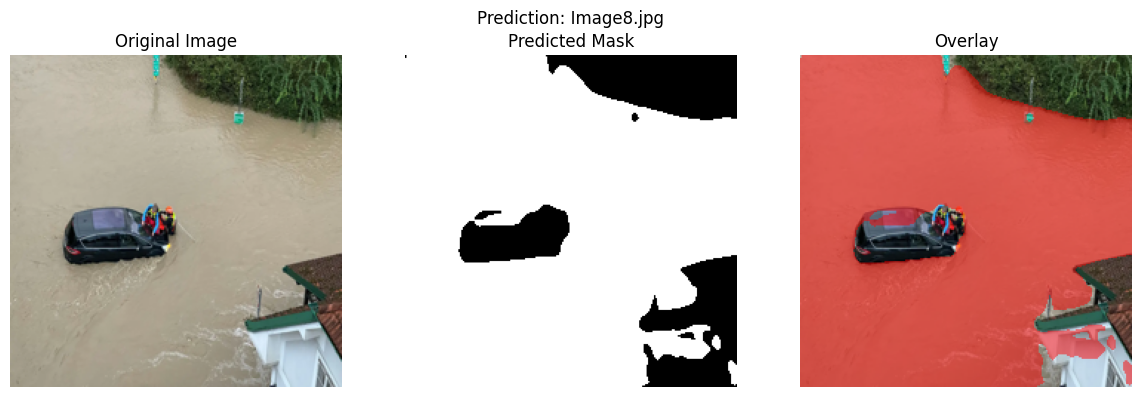

In [18]:
import import_ipynb
from utils.visualize_prediction import visualize_prediction
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_FOLDER = 'flood_images'  
ALPHA = 0.5  # Transparency of the mask

# load the model
model = load_model('./trained_models/flood_segmentation_model.keras', compile=False)

# use images for predictions
image_files = sorted(os.listdir(IMAGE_FOLDER))
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # preparation
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image_resized) / 255.0
    input_tensor = np.expand_dims(image_array, axis=0)  # Shape: (1, H, W, 3)

    # prediction
    pred_mask = model.predict(input_tensor)[0, :, :, 0]  # Shape: (H, W)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    visualize_prediction(
    image_resized=np.array(image_resized), 
    pred_binary=pred_binary, 
    img_file=img_file,
    alpha=ALPHA
)


## U-NET TODO: Performance des Modells weiter verbessern

- [x] Modell speichern - und außerdem noch mehr performance messungen machen - da hab ich in AIE (discord) auch einen link geteilt, der sich mit performance comparence befasst - vielleicht können wir was daraus entnehmen: https://www.kaggle.com/code/subhojeetroy01/flood-prediction-models-performance-comparison
  - Man kann jetzt mit `save_model` das Modell speichern und mit `load_model` laden
  - In `Data_augmentation.ipynb` wurde Intersection over Union (IoU) Metrik implementiert, die gut für Auswertung von Segmentation geeignet ist.   

- [ ] Wie? Anpassen der Parameter/hyperparameter zb
  - Und von diesem code vielleicht noch was übernehmen: https://www.kaggle.com/code/minhbau/flood-area-segmentation-deeplabv3-58f6e1/notebook

- [x] Add data augmentation: https://www.kaggle.com/code/dhaaivat20/unet-from-scratch
  - `Data_augmentation.ipynb`

[`Data_augmentation.ipynb`](https://colab.research.google.com/drive/1bkgYOLEVnUtxBD4WDqfA0yjWMbLgs7az?usp=sharing)


##### Übung 28.05.2025 -> TODOs:

ML-Pipeline: Business Probelm führt zu
- [x] Goal definition
- [x] DataCollection & preparation -> da ist ihnen wichtig dass wir - auch selbst daten labeln
- [x] Feature engineering -> das ist bei cnn nicht wirklich zu machen (bei uns ist data augmentation - gehört aber zu data preparation .... Filter drüberlegen usw machen CNN eh selber) - beispiel
- [x] Model training -> 1 Iteration trainieren und messern reicht nicht (Modell verbessern durch Feature engineering und data collection & preparation ändern (also schaun ob labeling passt) usw) -> auch Nachweis bringen dass Modell mit neuen (also unkenannten) Daten funktioniert (performance halten kann)
- [ ] Model evaluation
- [ ] Model deployment
- [ ] Model serving
- [ ] Model monitoring
- [ ] Model maintenance
- [ ] TODO: Data split - noch zeigen welche files in welchen foldern enthalten sind (also in image and mask jeweils train, validation and test inhalt ausgeben lassen)

Generell:

- Metriken überlegen und auch beschreiben warum sie für Bild Segmentierung gut sind

- auch selbständig Daten labeln (also bei uns die mask)

- ML-Pipeline -> dann für predictions eigene Bilder (google) verwenden und dann schaun ob es trotzdem nocht gut performt -> zb mit overlay von orig bild und predicted mask (dann sieht man zumindest visuell wie das funktioniert)

- Grafiken genererien die Code/Modell zeigen

- was sind unsere Schlüsse daraus

- beim nächsten Termin 10.06.2025 herzeigen, was wir schon gemacht haben

-> workflow
- mit Daten vertraut machen, visualisieren und anschaun
- Modell trainiert und Ergebnisse anschaut - und verbessern 1.Modell Daten anpassen, 2. Modell dann zb Hyperparameter (zb Learning rate) anpassen
- WElche Trainingsstrategien sind notwendig um Modell robust zu machen
- Deployment ist nicht so wichtig (aber ich denk das soll nur theoretisch durchgegangen werden)
- wichtig ist dieser iterativer Prozess -> neue Schichten einfügen, Normalisierung + Lernrate anpassen -> dann auch verstehen was die Änderungen bewirken usw.
- Vergleich von Werten (zb F1 score) mit anderen Arbeiten
- Effekt beschreiben, wenn ich Hyperparameter anpasse

CNN:
Stride = Schrittweite bei CNN (also wie Filter angewendet wird) - zero Padding = damit die Größe des inputs gleich bleibt (am Rand werden die zeros hinzugefügt damit schließlich wieder output selbe Größe hat

Wenn man sich die ARchitetur anschaun will von cnn zb
- tensorspace